In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

### Data Cleaning

In [25]:
# import 
df = pd.read_csv('../trainDataset.csv')
df = df[~(df == 999).any(axis=1)]
df.drop('ID', axis=1, inplace=True)

for i in range(12, len(df.columns)):
    df.columns.values[i] = 'img_' + str(i)

df = df.reset_index()

In [26]:
threshold = 4 # standard deviations from mean (99.7% of data)
for i, col_name in enumerate(df.columns[13:]):
    col = df[col_name]
    mean = np.mean(col)
    std = np.std(col)
    for j, x in enumerate(col):
        z = (x - mean) / std
        if z > threshold:
            df.iloc[j, i] = mean

In [27]:
# Assign features to X
X = df.drop('pCR (outcome)', axis=1).drop('RelapseFreeSurvival (outcome)', axis=1)
# Assign labels to y
y = df['pCR (outcome)']

In [28]:
X.drop('index', axis=1, inplace=True)

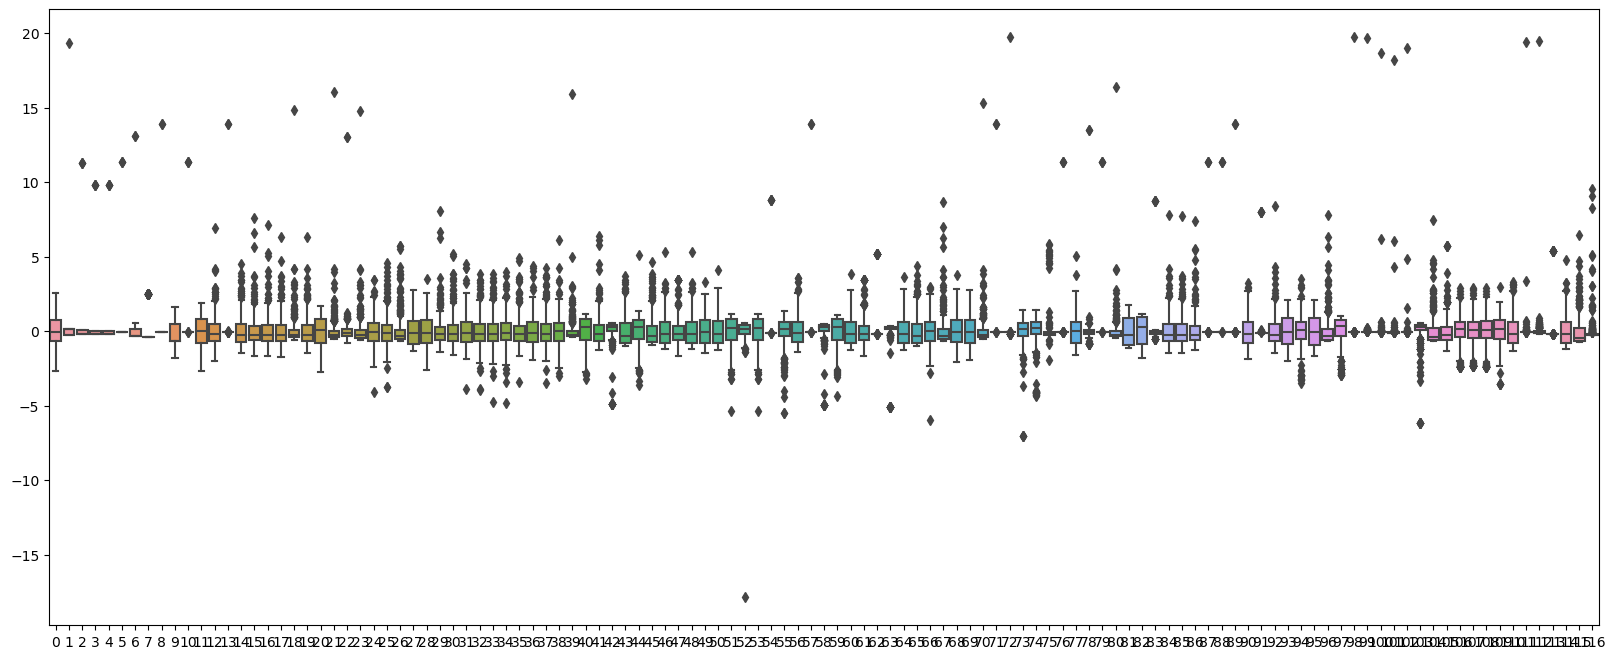

In [29]:
from sklearn.preprocessing import StandardScaler 

# Normalise the categorical features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X) 
fig,ax=plt.subplots(1,figsize=(20,8)) 
sns.boxplot(data=Xs,ax=ax)

In [30]:
from sklearn.decomposition import PCA

n_comp = 10
feature_names = list(X.columns) 
pca = PCA(n_components=0.90) # retain 90% of variance
img_pca = pca.fit_transform(Xs[:,10:])
print("N components:",pca.n_components_)

keep = 3
img_pca = img_pca[:,:keep] # retain the first 3 components
cols = ['pca_' + str(i+1) for i in range(keep)]
df_img_pca = pd.DataFrame(img_pca, columns=cols)

col_names = X.columns[:10]
Xs_pca = pd.concat([pd.DataFrame(Xs[:,:10], columns=col_names), df_img_pca], axis=1)

N components: 14


Perform SMOTE over-sampling to boost population of minority class (1)

In [31]:
from imblearn.over_sampling import SMOTE

Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

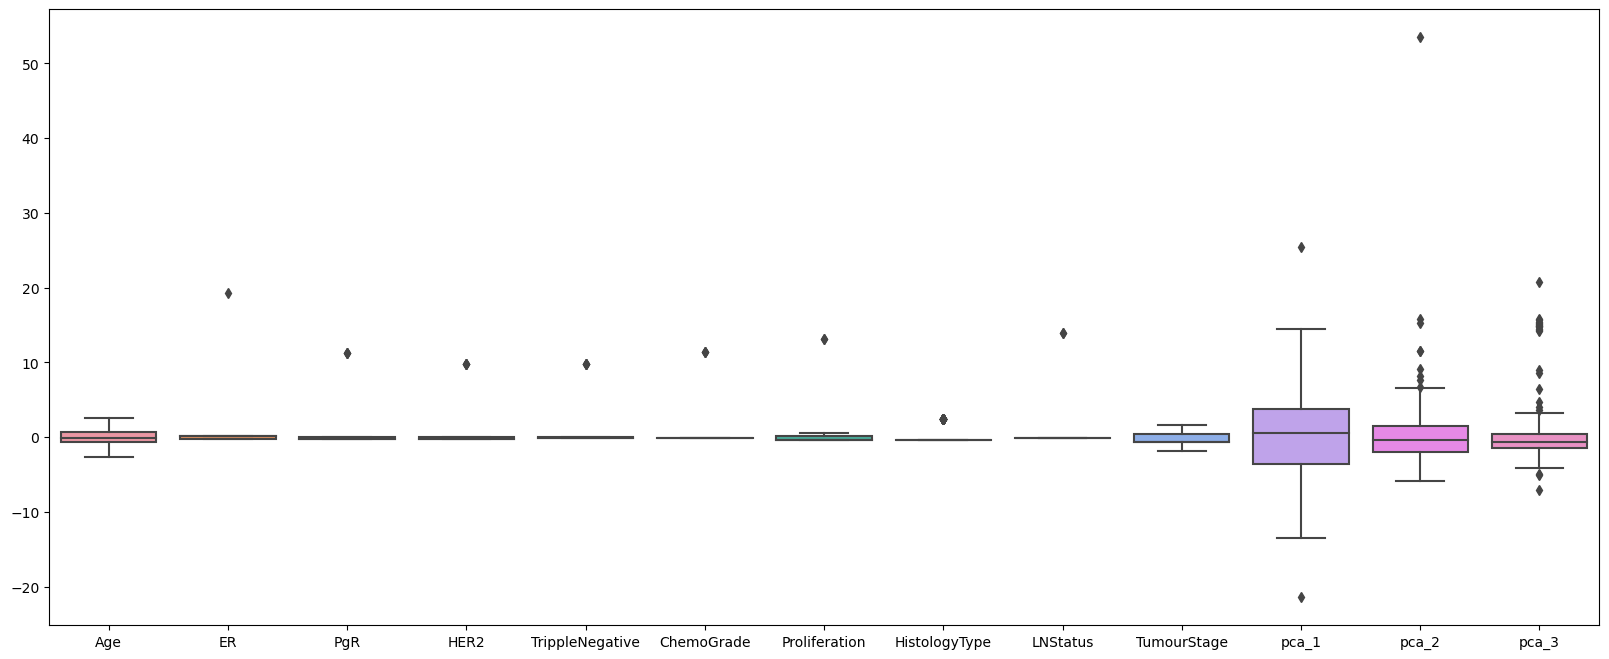

In [32]:
fig,ax=plt.subplots(1,figsize=(20,8)) 
sns.boxplot(data=Xs_pca,ax=ax)

## Artificial Neural Network

In [33]:
import tensorflow as tf
from tensorflow import keras

In [34]:
Xs_train, Xs_test, y_train, y_test = train_test_split(
                                        Xs_pca_resampled, 
                                        y_resampled, 
                                        test_size=0.2, 
                                        random_state=1, 
                                        stratify=y_resampled)

In [35]:
import keras_tuner as kt

### Tune model hyperparameters using keras tuner 

In [36]:
accuracy = keras.metrics.BinaryAccuracy()
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
sens_at_spec = keras.metrics.SensitivityAtSpecificity(0.8)

In [37]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(13,)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 4-64
    hp_units1 = hp.Int('units1', min_value=4, max_value=64, step=4)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics= [accuracy, precision])

    return model

In [38]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_binary_accuracy', direction='max'),
                     max_epochs=50,
                     factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [39]:
import os
import time

root_logdir = os.path.join(os.curdir, "tuner_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

# tensorboard for visualising the training process later 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

tuner.search(Xs_train, y_train, epochs=50, validation_split=0.2, 
        callbacks=[stop_early, tensorboard_cb])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


In [40]:
print(f"""
Hyperparameter search complete. 
Optimal number of units in layer is {best_hps.get('units1')} 
Optimal learning rate is {best_hps.get('learning_rate')}.
""")


Hyperparameter search complete. 
Optimal number of units in layer is 24 
Optimal learning rate is 0.1.



In [41]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(13,)))
model.add(keras.layers.Dense(24, activation="relu"))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                336       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1),
    metrics= [accuracy, precision])
model.save_weights('model.h1')

In [43]:
model.load_weights('model.h1')

history= model.fit(np.array(Xs_train), np.array(y_train), epochs=50, 
    validation_data=(np.array(Xs_test), np.array(y_test)))

Epoch 1/50
15/15 [==============================] - 1s 20ms/step - loss: 0.7408 - binary_accuracy: 0.5518 - precision_1: 0.5405 - val_loss: 0.6720 - val_binary_accuracy: 0.5882 - val_precision_1: 0.5902
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6642 - binary_accuracy: 0.6300 - precision_1: 0.6169 - val_loss: 0.6516 - val_binary_accuracy: 0.5798 - val_precision_1: 0.5694
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6526 - binary_accuracy: 0.6004 - precision_1: 0.5887 - val_loss: 0.6417 - val_binary_accuracy: 0.6471 - val_precision_1: 0.6500
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.6462 - binary_accuracy: 0.6385 - precision_1: 0.6275 - val_loss: 0.6490 - val_binary_accuracy: 0.6050 - val_precision_1: 0.5942
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.6366 - binary_accuracy: 0.6660 - precision_1: 0.6535 - val_loss: 0.6319 - val_binary_accuracy: 0.6303 - val_precision

4/4 [==============================] - 0s 2ms/step


Text(0.5, 1.05, 'Best ANN\n')

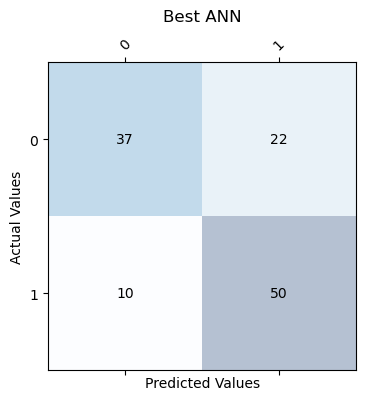

In [54]:
from sklearn.metrics import confusion_matrix

y_predict_prob = model.predict(Xs_test)
y_predict = []
for prob in y_predict_prob:
    if prob >= 0.5: y_predict.append(1)
    else:  y_predict.append(0)

cm = confusion_matrix(y_test, y_predict)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
 for j in range(cm.shape[1]):
     ax.text(x=j, y=i,
         s=cm[i, j], 
         va='center', ha='center')
classes=["0","1"]
tick_marks = np.arange(len(classes))
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('Actual Values', )
plt.title('Best ANN\n')

In [53]:
import sklearn.metrics as metrics

print(
    "Accuracy:\t", metrics.accuracy_score(y_predict, y_test),
    "\nPrecision:\t", metrics.precision_score(y_predict, y_test)
)

Accuracy:	 0.7310924369747899 
Precision:	 0.8333333333333334
